In [72]:
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt

class Elevator():
    '''
    ### Args ###
    current_floor: the floor where the elevator is at
    max_capacity: capacity of the elevator (number of people allowed)
    floor_queue_outside: which floors do we need to stop in for people to get in
    floor_queue_occupancy: which floors do we need to stop in for people to get out
    people_in_elevator: a list of objects of class Person that are currently in the elevator
    occupancy: number of people in the elevator (length of people_in_elevator)
    move_up: current direction of the elevator (True if up, False if down)

    ### Methods ###
    add_occupancy: adds people to the elevator from outside
    reduce_occupancy: removes people from the elevator
    move_basic_strategy: basic strategy (described in the function)
    move_strategy3: updated strategy (described in the function)
    '''
    def __init__(self, current_floor, max_capacity, floor_queue_outside):
        self.current_floor = current_floor
        self.max_capacity = max_capacity
        self.floor_queue_occupancy = []
        self.floor_queue_outside = floor_queue_outside
        self.people_in_elevator = []
        self.occupancy = len(self.people_in_elevator)
        self.move_up = True


    def add_occupancy(self, people_in_building):
        _open = False
        # check whether the elevator is full and if there are people at this floor
#         print(self.current_floor, len(people_in_building))
        while (self.occupancy < self.max_capacity and len(people_in_building[self.current_floor]) > 0):
            # exclude the person who entered the elevator from the line
            person = people_in_building[self.current_floor].pop()
            # add the person to the ones in the elevator
            self.people_in_elevator.append(person)
            # add the floor the person who just entered needs to stop at
            self.floor_queue_occupancy.append(person.stop_floor)
            self.floor_queue_occupancy = list(set(self.floor_queue_occupancy))
            
            _open = True
        self.occupancy = len(self.people_in_elevator)
        return people_in_building, _open
    
    def reduce_occupancy(self):
        _open = False
        for person in self.people_in_elevator:
                # check whether the elevator needs to stop at the current floor
                if person.stop_floor == self.current_floor:
                    # Remove the floor from the queue of floors we need to stop at
                    if self.current_floor in self.floor_queue_occupancy:
                        self.floor_queue_occupancy.pop(self.floor_queue_occupancy.index(self.current_floor))
                    self.people_in_elevator.pop(self.people_in_elevator.index(person))
                    _open = True
        self.occupancy = len(self.people_in_elevator)
        return _open
    
    def move_basic_strategy(self, num_floors):
        '''
        Basic strategy:
        The elevator goes all the way up, then all the way down and repeat, openning the door
        only when required to pick up or drop off.
        '''
        
        # Elevator goes up until reaches top floor, then goes down until floor 0
        if self.current_floor == num_floors - 1:
            self.move_up = False
        elif self.current_floor == 0:
            self.move_up = True
        # Move elevator to the next floor (up or down, based on indicator)
        if self.move_up == True:
            self.current_floor += 1
        else:
            self.current_floor -= 1


    def move_strategy3(self, num_floors):
        '''
        Updated strategy:
        The elevator goes up only until where it is required to (based on the queues of passengers).
        The door opens only when required to pick up or drop off.
        '''
        
        # Join both queues (pick up and drop off) so that we can set the bounds of the floors.
        queue_all = self.floor_queue_occupancy + self.floor_queue_outside
        if queue_all:
            bound_high = max(queue_all)
            bound_low = min(queue_all)
        else:
            bound_high = num_floors - 1
            bound_low = 0 
        
        # If high bound, start moving down and vice verse
        if self.current_floor == bound_high:
            self.move_up = False
        elif self.current_floor == bound_low:
            self.move_up = True
        # Fail safe: if top floor move down, if bottom floor move up
        elif self.current_floor == num_floors - 1:
            self.move_up = False
        elif self.current_floor == 0:
            self.move_up = True
        
        # Move elevator to the next floor (up or down, based on indicator)
        if self.move_up == True:
            self.current_floor += 1
        else:
            self.current_floor -= 1

            

class Building():
    '''
    ###Args###
    num_floors: the number of floors in the building
    num_passengers: the number of people entering the elevator
    people_in_building: a list of lists, one for each floor. Each sublist contains
                        objects of class Passenger with the number of people in each
                        floor waiting for the elevator.

    ###Methods###
    extract_floor_queue_outside: collect the information about the floor destinations of the passengers
    total_current_waiting: the number of people waiting for the elevator or for their floor in the elevator
    update: update the line for the elevator after some pasengers reached their destination
    
    ###Output###
    A building object
    '''
    def __init__(self, num_floors, num_passenger, passenger_type):
        self.num_floors = num_floors
        self.num_passengers = num_passenger
        self.people_in_building = [[] for _ in range(self.num_floors)]
        self.passenger_type = passenger_type
        
        # Initiate the people
        for i in range(self.num_passengers):
            temp_person = Passenger(self.num_floors, self.passenger_type) 
            self.people_in_building[temp_person.start_floor].append(temp_person)

    def extract_floor_queue_outside(self):
        floor_queue_outside = []
        for i in range(len(self.people_in_building)):
            if len(self.people_in_building[i]) > 0:
                floor_queue_outside.append(i)
        return floor_queue_outside

    def total_current_waiting(self):
        counter = 0
        # get the total number of people that need to get to a different floor 
        for f in range(len(self.people_in_building)):
            counter += len(self.people_in_building[f])
        return counter

    def update(self, _people_in_building):
        self.people_in_building = _people_in_building

class Passenger():
    '''
    ###Args###:
    num_floor: number of floors the passenger in the building
    start_floor: the floor that the passenger leaves from. The floor is chosen from
                 a distribution with the same probability for all floors apart from
                 the zero floor which has a probability larger by a factor of num_floor
                 (the probability of the zero floor is equal to the sum of probabilities
                 of all other floors).
    stop_floot: the floor that the passenger needs to get to. The floor is chosen from
                the same distribution of the start_floor. 
    
    ###Output###:
    A passenger object
    '''
    def __init__(self, num_floor, passenger_type): 
        if passenger_type == 'uniform':
            self.start_floor = int(sts.uniform(0, num_floor).rvs())
            self.stop_floor = int(sts.uniform(0, num_floor).rvs())
            self.start_floor = np.random.choice(range(num_floor))
            self.stop_floor = np.random.choice(range(num_floor))
            while self.stop_floor == self.start_floor: 
                self.stop_floor = np.random.choice(range(num_floor))
        else:
            floor_list = np.zeros(num_floor)
            floor_list = np.concatenate((floor_list, range(1, num_floor)), axis=0)
            self.start_floor = int(np.random.choice(floor_list))
            self.stop_floor = int(np.random.choice(floor_list))
            while self.stop_floor == self.start_floor: 
                self.stop_floor = int(np.random.choice(floor_list))

class Simulator_1():
    '''
    ###Args###
    num_floors: number of floors in the building
    num_passengers: number of passengers taking the elevator
    
    ###Methods###
    
    
    ###Output###
    
    '''
    def __init__(self, num_floors, num_passengers, passenger_type): 
        self.time = 0
        self.num_floors = num_floors
        self.num_passengers = num_passengers
        self.total_waiting_time = 0
        self.passenger_type = passenger_type


    def simulate(self): 
        #Initialization
        building = Building(self.num_floors, self.num_passengers, self.passenger_type)
        elevator = Elevator(current_floor=0, max_capacity=10, floor_queue_outside = building.extract_floor_queue_outside())
        
        #Main loop
        initiate = True
        floor_count = 0
        while building.total_current_waiting() > 0 or (elevator.occupancy > 0 or initiate):
            initiate = False
            # Elevator goes up until reaches top floor, then goes down until floor 0.
            
            
            elevator.move_basic_strategy(building.num_floors)
            
            # Drop all people that need this floor
            isOpen_reduce = elevator.reduce_occupancy()
            
            # Picking up people from the floor
            new_people_in_building, isOpen_add = elevator.add_occupancy(building.people_in_building)
            building.update(new_people_in_building)
            
            # if we opened the door for adding or for dropping
            if isOpen_reduce or isOpen_add:
                self.time += 1
                floor_count += 1
                self.total_waiting_time += building.total_current_waiting() + elevator.occupancy
            
            # Adding the waiting time of all people in this time step to the total
            self.time += 1
            self.total_waiting_time += building.total_current_waiting() + elevator.occupancy
#             print("CWT = {cwt}, Occupancy = {o}".format(cwt=building.total_current_waiting(), o=elevator.occupancy))
#             print("Time {t}: Total waiting time = {twt}".format(t=self.time, twt=self.total_waiting_time))
            
            # Update the queue of floors to visit
            elevator.floor_queue_outside = building.extract_floor_queue_outside()
        return self.total_waiting_time, self.time, floor_count
            
class Simulator_2():
    '''
    ###Args###
    num_floors: number of floors in the building
    num_passengers: number of passengers taking the elevator
    
    ###Methods###
    
    
    ###Output###
    
    '''
    def __init__(self, num_floors, num_passengers, passenger_type): 
        self.time = 0
        self.num_floors = num_floors
        self.num_passengers = num_passengers
        self.total_waiting_time = 0
        self.passenger_type = passenger_type


    def simulate(self): 
        #Initialization
        building = Building(self.num_floors, self.num_passengers, self.passenger_type)
        elevator = Elevator(current_floor=0, max_capacity=10, floor_queue_outside = building.extract_floor_queue_outside())
        
        #Main loop
        initiate = True
        floor_count = 0
        while building.total_current_waiting() > 0 or (elevator.occupancy > 0 or initiate):
            initiate = False
            # Elevator goes up until reaches top floor, then goes down until floor 0.
            elevator.move_strategy3(building.num_floors)
            
            # Drop all people that need this floor
            isOpen_reduce = elevator.reduce_occupancy()
            
            # Picking up people from the floor
            new_people_in_building, isOpen_add = elevator.add_occupancy(building.people_in_building)
            building.update(new_people_in_building)
            
            # if we opened the door for adding or for dropping
            if isOpen_reduce or isOpen_add:
                self.time += 1
                self.total_waiting_time += building.total_current_waiting() + elevator.occupancy
                floor_count += 1
            
            # Adding the waiting time of all people in this time step to the total
            self.time += 1
            self.total_waiting_time += building.total_current_waiting() + elevator.occupancy
#             print("CWT = {cwt}, Occupancy = {o}".format(cwt=building.total_current_waiting(), o=elevator.occupancy))
#             print("Time {t}: Total waiting time = {twt}".format(t=self.time, twt=self.total_waiting_time))
            
            # Update the queue of floors to visit
            elevator.floor_queue_outside = building.extract_floor_queue_outside()
        return self.total_waiting_time, self.time, floor_count
    
class Simulator_3():
    '''
    ###Args###
    num_floors: number of floors in the building
    num_passengers: number of passengers taking the elevator
    
    ###Methods###
    
    
    ###Output###
    
    '''
    def __init__(self, num_floors, num_passengers, passenger_type): 
        self.time = 0
        self.num_floors = num_floors
        self.num_passengers = num_passengers
        self.total_waiting_time = 0
        self.passenger_type = passenger_type

    def simulate(self): 
        #Initialization
        building = Building(self.num_floors, self.num_passengers, self.passenger_type)
        elevator = Elevator(current_floor=0, max_capacity=10, floor_queue_outside = building.extract_floor_queue_outside)
        
        #Main loop
        initiate = True
        floor_count = 0
        while building.total_current_waiting() > 0 or (elevator.occupancy > 0 or initiate):
            initiate = False
    
            # Drop all people that need this floor
            isOpen_reduce = elevator.reduce_occupancy()
            
            # Picking up people from the floor
            new_people_in_building, isOpen_add = elevator.add_occupancy(building.people_in_building)
            building.update(new_people_in_building)
            
            
            # if we opened the door for adding or for dropping
            if True:
                self.time += 1
                self.total_waiting_time += building.total_current_waiting() + elevator.occupancy
                floor_count += 1
                
            # Elevator goes up until reaches top floor, then goes down until floor 0.            
            elevator.move_basic_strategy(building.num_floors)
            
            # Adding the waiting time of all people in this time step to the total
            self.time += 1
            self.total_waiting_time += building.total_current_waiting() + elevator.occupancy
#             print("CWT = {cwt}, Occupancy = {o}".format(cwt=building.total_current_waiting(), o=elevator.occupancy))
#             print("Time {t}: Total waiting time = {twt}".format(t=self.time, twt=self.total_waiting_time))
        return self.total_waiting_time, self.time, floor_count


simulator1 = Simulator_1(num_floors=40, num_passengers=30, passenger_type = 'uniform')
simulator1.simulate()

(2248, 181, 41)

# Uniform Distributed Passenger

In [2]:
wt_1, wt_2, wt_3 = [], [], []
t_1, t_2, t_3 = [], [], []



for _ in range(100):
    simulator1 = Simulator_1(num_floors=10, num_passengers=30, passenger_type='uniform')
    simulator2 = Simulator_2(num_floors=10, num_passengers=30, passenger_type='uniform')
    simulator3 = Simulator_3(num_floors=10, num_passengers=30, passenger_type='uniform')
    wait_time1, time1 = simulator1.simulate()
    wt_1.append(wait_time1)
    t_1.append(time1)
    wait_time2, time2 = simulator2.simulate()
    wt_2.append(wait_time2)
    t_2.append(time2)
    wait_time3, time3 = simulator3.simulate()
    wt_3.append(wait_time3)
    t_3.append(time3)
    
print('Average waiting time for strategy 1:', sum(wt_1)/len(wt_1))
print('Average waiting time for strategy 2:', sum(wt_2)/len(wt_2))
print('Average waiting time for strategy 3:', sum(wt_3)/len(wt_3))

print('Average time for strategy 1:', sum(t_1)/len(t_1))
print('Average time for strategy 2:', sum(t_2)/len(t_2))
print('Average time for strategy 3:', sum(t_3)/len(t_3))

Average waiting time for strategy 1: 857.58
Average waiting time for strategy 2: 865.73
Average waiting time for strategy 3: 967.56
Average time for strategy 1: 69.03
Average time for strategy 2: 69.18
Average time for strategy 3: 90.44


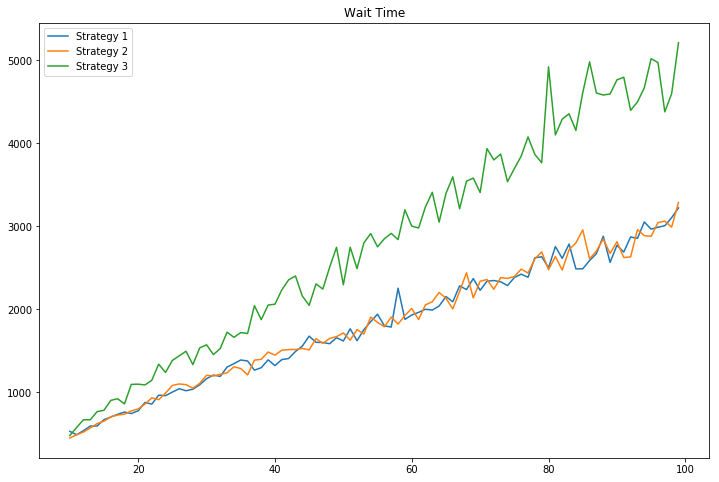

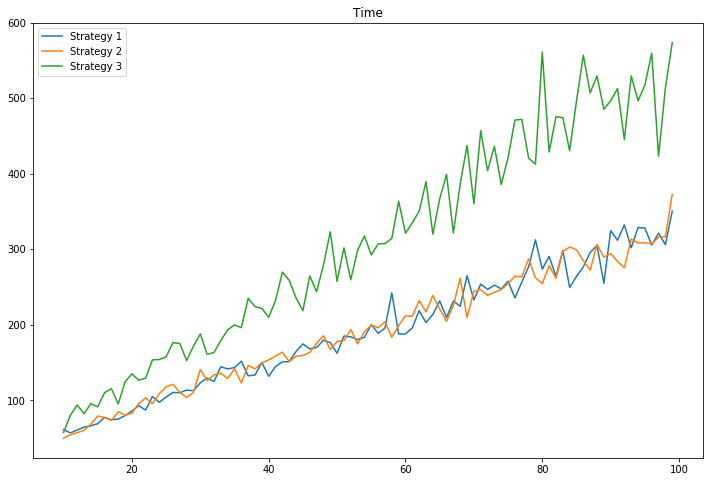

In [3]:
l1, l2, l3 = [], [], []
l4, l5, l6 = [], [], []

_range = range(10, 100)

for i in _range:
    wt_1, wt_2, wt_3 = [], [], []
    t_1, t_2, t_3 = [], [], []
    for _ in range(10):
        simulator1 = Simulator_1(num_floors=i, num_passengers=20, passenger_type='uniform')
        simulator2 = Simulator_2(num_floors=i, num_passengers=20, passenger_type='uniform')
        simulator3 = Simulator_3(num_floors=i, num_passengers=20, passenger_type='uniform')
        wait_time1, time1 = simulator1.simulate()
        wt_1.append(wait_time1)
        t_1.append(time1)
        wait_time2, time2 = simulator2.simulate()
        wt_2.append(wait_time2)
        t_2.append(time2)
        wait_time3, time3 = simulator3.simulate()
        wt_3.append(wait_time3)
        t_3.append(time3)
    l1.append(sum(wt_1)/len(wt_1))
    l2.append(sum(wt_2)/len(wt_2))
    l3.append(sum(wt_3)/len(wt_3))
    l4.append(sum(t_1)/len(t_1))
    l5.append(sum(t_2)/len(t_2))
    l6.append(sum(t_3)/len(t_3))

    
plt.figure(figsize=(12,8))
plt.plot(_range, l1, label='Strategy 1')
plt.plot(_range, l2, label='Strategy 2')
plt.plot(_range, l3, label='Strategy 3')
plt.legend()
plt.title('Wait Time')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(_range, l4, label='Strategy 1')
plt.plot(_range, l5, label='Strategy 2')
plt.plot(_range, l6, label='Strategy 3')
plt.legend()
plt.title('Time')
plt.show()

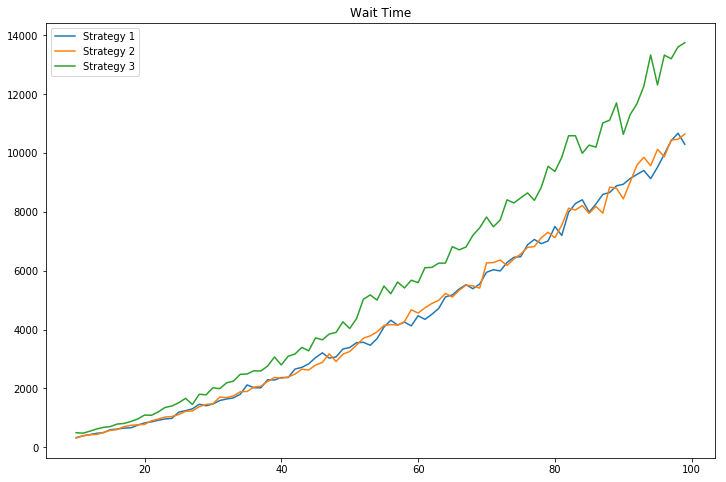

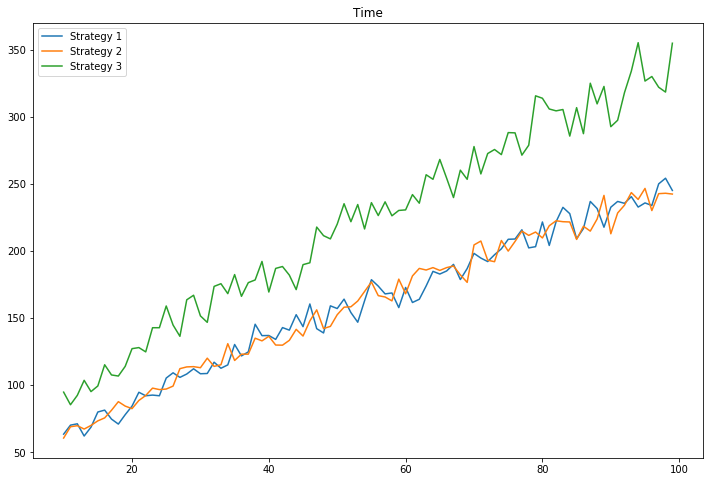

In [5]:
l1, l2, l3 = [], [], []
l4, l5, l6 = [], [], []

_range = range(10, 100)

for i in _range:
    wt_1, wt_2, wt_3 = [], [], []
    t_1, t_2, t_3 = [], [], []
    for _ in range(10):
        simulator1 = Simulator_1(num_floors=20, num_passengers=i, passenger_type='uniform')
        simulator2 = Simulator_2(num_floors=20, num_passengers=i, passenger_type='uniform')
        simulator3 = Simulator_3(num_floors=20, num_passengers=i, passenger_type='uniform')
        wait_time1, time1 = simulator1.simulate()
        wt_1.append(wait_time1)
        t_1.append(time1)
        wait_time2, time2 = simulator2.simulate()
        wt_2.append(wait_time2)
        t_2.append(time2)
        wait_time3, time3 = simulator3.simulate()
        wt_3.append(wait_time3)
        t_3.append(time3)
    l1.append(sum(wt_1)/len(wt_1))
    l2.append(sum(wt_2)/len(wt_2))
    l3.append(sum(wt_3)/len(wt_3))
    l4.append(sum(t_1)/len(t_1))
    l5.append(sum(t_2)/len(t_2))
    l6.append(sum(t_3)/len(t_3))

    
plt.figure(figsize=(12,8))
plt.plot(_range, l1, label='Strategy 1')
plt.plot(_range, l2, label='Strategy 2')
plt.plot(_range, l3, label='Strategy 3')
plt.legend()
plt.title('Wait Time')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(_range, l4, label='Strategy 1')
plt.plot(_range, l5, label='Strategy 2')
plt.plot(_range, l6, label='Strategy 3')
plt.legend()
plt.title('Time')
plt.show()

# Ground Floor Concentrating Passenger

In [6]:
wt_1, wt_2, wt_3 = [], [], []
t_1, t_2, t_3 = [], [], []



for _ in range(100):
    simulator1 = Simulator_1(num_floors=10, num_passengers=30, passenger_type='ground')
    simulator2 = Simulator_2(num_floors=10, num_passengers=30, passenger_type='ground')
    simulator3 = Simulator_3(num_floors=10, num_passengers=30, passenger_type='ground')
    wait_time1, time1 = simulator1.simulate()
    wt_1.append(wait_time1)
    t_1.append(time1)
    wait_time2, time2 = simulator2.simulate()
    wt_2.append(wait_time2)
    t_2.append(time2)
    wait_time3, time3 = simulator3.simulate()
    wt_3.append(wait_time3)
    t_3.append(time3)
    
print('Average waiting time for strategy 1:', sum(wt_1)/len(wt_1))
print('Average waiting time for strategy 2:', sum(wt_2)/len(wt_2))
print('Average waiting time for strategy 3:', sum(wt_3)/len(wt_3))

print('Average time for strategy 1:', sum(t_1)/len(t_1))
print('Average time for strategy 2:', sum(t_2)/len(t_2))
print('Average time for strategy 3:', sum(t_3)/len(t_3))

Average waiting time for strategy 1: 1108.99
Average waiting time for strategy 2: 1099.09
Average waiting time for strategy 3: 951.34
Average time for strategy 1: 88.21
Average time for strategy 2: 88.67
Average time for strategy 3: 128.0


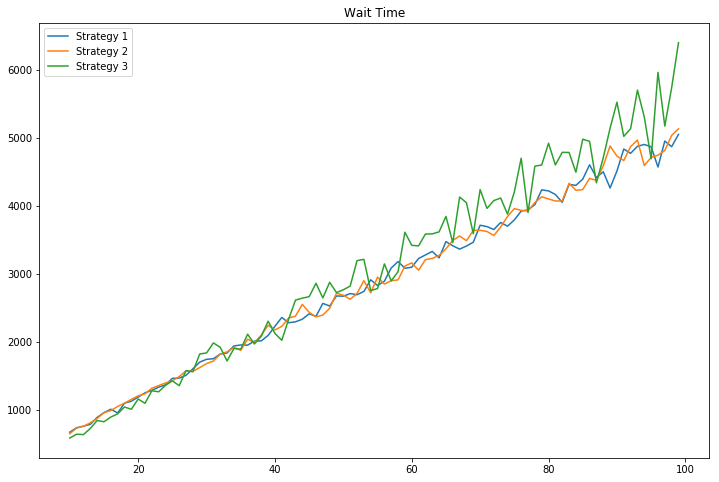

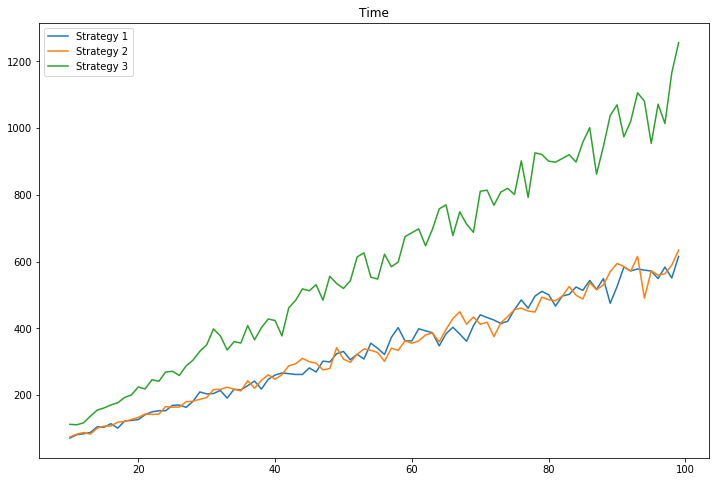

In [7]:
l1, l2, l3 = [], [], []
l4, l5, l6 = [], [], []

_range = range(10, 100)

for i in _range:
    wt_1, wt_2, wt_3 = [], [], []
    t_1, t_2, t_3 = [], [], []
    for _ in range(10):
        simulator1 = Simulator_1(num_floors=i, num_passengers=20, passenger_type='ground')
        simulator2 = Simulator_2(num_floors=i, num_passengers=20, passenger_type='ground')
        simulator3 = Simulator_3(num_floors=i, num_passengers=20, passenger_type='ground')
        wait_time1, time1 = simulator1.simulate()
        wt_1.append(wait_time1)
        t_1.append(time1)
        wait_time2, time2 = simulator2.simulate()
        wt_2.append(wait_time2)
        t_2.append(time2)
        wait_time3, time3 = simulator3.simulate()
        wt_3.append(wait_time3)
        t_3.append(time3)
    l1.append(sum(wt_1)/len(wt_1))
    l2.append(sum(wt_2)/len(wt_2))
    l3.append(sum(wt_3)/len(wt_3))
    l4.append(sum(t_1)/len(t_1))
    l5.append(sum(t_2)/len(t_2))
    l6.append(sum(t_3)/len(t_3))

    
plt.figure(figsize=(12,8))
plt.plot(_range, l1, label='Strategy 1')
plt.plot(_range, l2, label='Strategy 2')
plt.plot(_range, l3, label='Strategy 3')
plt.legend()
plt.title('Wait Time')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(_range, l4, label='Strategy 1')
plt.plot(_range, l5, label='Strategy 2')
plt.plot(_range, l6, label='Strategy 3')
plt.legend()
plt.title('Time')
plt.show()

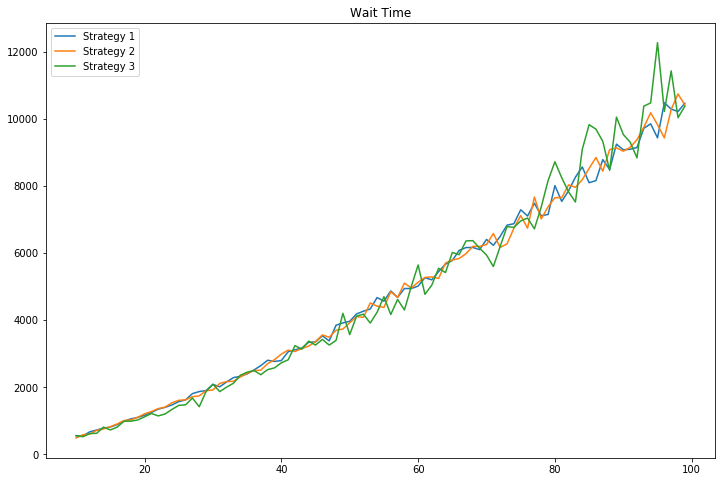

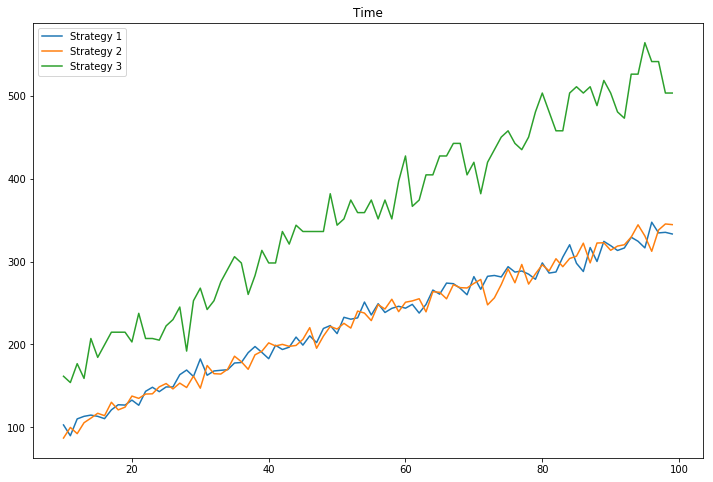

In [9]:
l1, l2, l3 = [], [], []
l4, l5, l6 = [], [], []

_range = range(10, 100)

for i in _range:
    wt_1, wt_2, wt_3 = [], [], []
    t_1, t_2, t_3 = [], [], []
    for _ in range(10):
        simulator1 = Simulator_1(num_floors=20, num_passengers=i, passenger_type='ground')
        simulator2 = Simulator_2(num_floors=20, num_passengers=i, passenger_type='ground')
        simulator3 = Simulator_3(num_floors=20, num_passengers=i, passenger_type='ground')
        wait_time1, time1 = simulator1.simulate()
        wt_1.append(wait_time1)
        t_1.append(time1)
        wait_time2, time2 = simulator2.simulate()
        wt_2.append(wait_time2)
        t_2.append(time2)
        wait_time3, time3 = simulator3.simulate()
        wt_3.append(wait_time3)
        t_3.append(time3)
    l1.append(sum(wt_1)/len(wt_1))
    l2.append(sum(wt_2)/len(wt_2))
    l3.append(sum(wt_3)/len(wt_3))
    l4.append(sum(t_1)/len(t_1))
    l5.append(sum(t_2)/len(t_2))
    l6.append(sum(t_3)/len(t_3))

    
plt.figure(figsize=(12,8))
plt.plot(_range, l1, label='Strategy 1')
plt.plot(_range, l2, label='Strategy 2')
plt.plot(_range, l3, label='Strategy 3')
plt.legend()
plt.title('Wait Time')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(_range, l4, label='Strategy 1')
plt.plot(_range, l5, label='Strategy 2')
plt.plot(_range, l6, label='Strategy 3')
plt.legend()
plt.title('Time')
plt.show()